In [ ]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install numpy matplotlib scikit-learn


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [37]:

# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, hidden_size]
        outputs, (hidden, cell) = self.lstm(embedded)  # [batch_size, seq_len, hidden_size], [num_layers, batch_size, hidden_size]
        return outputs, hidden, cell

In [38]:

# Attention class
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1)  # [batch_size, 1, hidden_size]
        attn_weights = torch.bmm(encoder_outputs, hidden.transpose(1, 2))  # [batch_size, seq_len, 1]
        attn_weights = torch.softmax(attn_weights.squeeze(2), dim=-1)  # [batch_size, seq_len]
        context_vector = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [batch_size, hidden_size]
        return context_vector

In [39]:

# Decoder class
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = Attention(hidden_size)
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        embedded = self.embedding(x).unsqueeze(1)  # [batch_size, 1, hidden_size]
        context_vector = self.attention(hidden[0], encoder_outputs)  # [batch_size, hidden_size]
        lstm_input = torch.cat((embedded.squeeze(1), context_vector), dim=-1)  # [batch_size, hidden_size * 2]
        output, (hidden, cell) = self.lstm(lstm_input.unsqueeze(1), (hidden, cell))  # [batch_size, hidden_size]
        output = self.fc_out(output.squeeze(1))  # [batch_size, output_size]
        return output, hidden, cell

In [40]:

# Seq2Seq class
class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(hidden_size, output_size, num_layers)

    def forward(self, source, target):
        encoder_outputs, hidden, cell = self.encoder(source)
        batch_size = source.size(0)
        target_len = target.size(1)
        output_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, target_len, output_size).to(source.device)

        input_token = target[:, 0]  # Initialize with the start token
        for t in range(1, target_len):  # Start from the second token
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            input_token = output.argmax(dim=-1)  # Get the next token

        return outputs

In [43]:

# Generate synthetic data
def generate_data(num_samples=1000, seq_len=10, input_size=10):
    source_seq = np.random.randint(1, input_size, size=(num_samples, seq_len))
    target_seq = np.flip(source_seq, axis=1)  # Target is the reverse of source
    # Fix the stride issue by creating a copy of the array
    return torch.tensor(source_seq.copy(), dtype=torch.long), torch.tensor(target_seq.copy(), dtype=torch.long)

# Hyperparameters
input_size = 10  # Vocabulary size
output_size = 10  # Vocabulary size
hidden_size = 256
num_layers = 2
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Generate data
source_data, target_data = generate_data()

# Convert source and target data to pandas DataFrame for saving as CSV
data_dict = {
    'source': [','.join(map(str, seq)) for seq in source_data.numpy()],
    'target': [','.join(map(str, seq)) for seq in target_data.numpy()]
}

# Create a DataFrame
df = pd.DataFrame(data_dict)

# Save the DataFrame to a CSV file
df.to_csv('dataset.csv', index=False)


In [44]:

# Split the dataset into training and testing
train_size = int(0.8 * len(source_data))
train_source = source_data[:train_size]
train_target = target_data[:train_size]
test_source = source_data[train_size:]
test_target = target_data[train_size:]

# Create DataLoader for batch processing
train_dataset = TensorDataset(train_source, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(input_size, output_size, hidden_size, num_layers).to(device)


In [45]:

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train(model, train_loader, num_epochs):
    model.train()
    total_loss = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for source_batch, target_batch in train_loader:
            source_batch, target_batch = source_batch.to(device), target_batch.to(device)

            optimizer.zero_grad()
            output = model(source_batch, target_batch)

            # Reshape output and target for loss calculation
            output = output[:, 1:].reshape(-1, output_size)  # Remove start token
            target_batch = target_batch[:, 1:].reshape(-1)  # Remove start token

            loss = criterion(output, target_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        total_loss.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

    return total_loss


Epoch 1/10, Loss: 2.1623323422211866
Epoch 2/10, Loss: 1.8120158268855169
Epoch 3/10, Loss: 1.5737004646888146
Epoch 4/10, Loss: 1.363832712173462
Epoch 5/10, Loss: 1.144301176071167
Epoch 6/10, Loss: 0.9016830646074735
Epoch 7/10, Loss: 0.6683658269735483
Epoch 8/10, Loss: 0.524586198421625
Epoch 9/10, Loss: 0.4140589145513681
Epoch 10/10, Loss: 0.31706363077347094


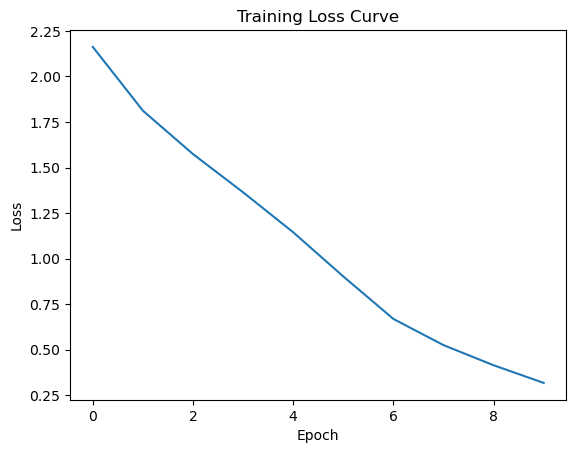

In [46]:

# Train the model
train_loss = train(model, train_loader, num_epochs)

# Plot the loss curve
plt.plot(train_loss)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [47]:
def calculate_accuracy(model, source_data, target_data, batch_size):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for i in range(0, len(source_data), batch_size):
            source_batch = source_data[i:i + batch_size].to(device)
            target_batch = target_data[i:i + batch_size].to(device)

            output = model(source_batch, target_batch)

            # Get the predicted tokens (argmax of the output)
            output_tokens = output.argmax(dim=-1)

            # Compare predictions with actual target (excluding the first token)
            correct += (output_tokens[:, 1:] == target_batch[:, 1:]).sum().item()  # Compare tokens from the second onward
            total += target_batch.size(0) * (target_batch.size(1) - 1)  # Exclude start token from total count

    accuracy = correct / total * 100  # Percentage accuracy
    return accuracy

In [48]:
# Calculate accuracy after training
accuracy = calculate_accuracy(model, test_source, test_target, batch_size)
print(f"Accuracy on test data: {accuracy:.2f}%")


Accuracy on test data: 94.22%
